# Asian Cuisine Restaurant Business Locations Recommendation In Toronto

## Problem Statment:

## Sometimes when you would like to start a restaurant in Toronto, you have no clue where would be best locations that maximizes your chances of being successful.

## This project aims to provide insights for people who want to start up a new Asian cuisine restaurant bussiness but worried about location picking as it provides insights for them which neighborhood areas are the best candidates

---

# Data Cleaning & Visualization

In [36]:
import requests,urllib,json
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import cufflinks as cf
import re
import folium
import geopy
import geopandas

init_notebook_mode()
latitude_toronto = 43.651070
longitude_toronto = -79.347015

## Load Toronto 2016 census dataset

In [37]:
df = pd.read_csv("neighbourhood-profiles-2016-csv.csv")
df.head()

_id                   Category                      Topic  \
0    1  Neighbourhood Information  Neighbourhood Information   
1    2  Neighbourhood Information  Neighbourhood Information   
2    3                 Population   Population and dwellings   
3    4                 Population   Population and dwellings   
4    5                 Population   Population and dwellings   

                      Data Source               Characteristic  \
0                 City of Toronto         Neighbourhood Number   
1                 City of Toronto         TSNS2020 Designation   
2  Census Profile 98-316-X2016001             Population, 2016   
3  Census Profile 98-316-X2016001             Population, 2011   
4  Census Profile 98-316-X2016001  Population Change 2011-2016   

  City of Toronto Agincourt North Agincourt South-Malvern West  \
0             NaN             129                          128   
1             NaN  No Designation               No Designation   
2       2,731,571          29,113                       23,757   
3       2,615,060          30,279                       21,988   
4           4.50%          -3.90%                        8.00%   

        Alderwood           Annex  ... Willowdale West  \
0              20              95  ...              37   
1  No Designation  No Designation  ...  No Designation   
2          12,054          30,526  ...          16,936   
3          11,904          29,177  ...          15,004   
4           1.30%           4.60%  ...          12.90%   

  Willowridge-Martingrove-Richview  Woburn Woodbine Corridor Woodbine-Lumsden  \
0                                7     137                64               60   
1                   No Designation     NIA    No Designation   No Designation   
2                           22,156  53,485            12,541            7,865   
3                           21,343  53,350            11,703            7,826   
4                            3.80%   0.30%             7.20%            0.50%   

         Wychwood  Yonge-Eglinton  Yonge-St.Clair York University Heights  \
0              94             100              97                      27   
1  No Designation  No Designation  No Designation                     NIA   
2          14,349          11,817          12,528                  27,593   
3          13,986          10,578          11,652                  27,713   
4           2.60%          11.70%           7.50%                  -0.40%   

       Yorkdale-Glen Park  
0                      31  
1  Emerging Neighbourhood  
2                  14,804  
3                  14,687  
4                   0.80%  

[5 rows x 146 columns]

In [38]:
df.rename(columns={'Cabbagetown-South St. James Town':'Cabbagetown-South St.James Town','North St. James Town':'North St.James Town','Weston-Pelham Park':'Weston-Pellam Park'},inplace=True)

# ['Cabbagetown-South St.James Town', 'North St.James Town',
#        'Weston-Pellam Park']

---

## Population in each neighborhood

In [39]:
df_population = df.loc[(df.Category == 'Population') & (df.Characteristic == 'Population, 2016')].iloc[:,6:].transpose().reset_index().copy()
df_population.columns = ['Neighborhood','Population']
df_population['Population'] = df_population['Population'].apply(lambda x: int(x.replace(',','')))
df_population

Neighborhood  Population
0                 Agincourt North       29113
1    Agincourt South-Malvern West       23757
2                       Alderwood       12054
3                           Annex       30526
4               Banbury-Don Mills       27695
..                            ...         ...
135                      Wychwood       14349
136                Yonge-Eglinton       11817
137                Yonge-St.Clair       12528
138       York University Heights       27593
139            Yorkdale-Glen Park       14804

[140 rows x 2 columns]

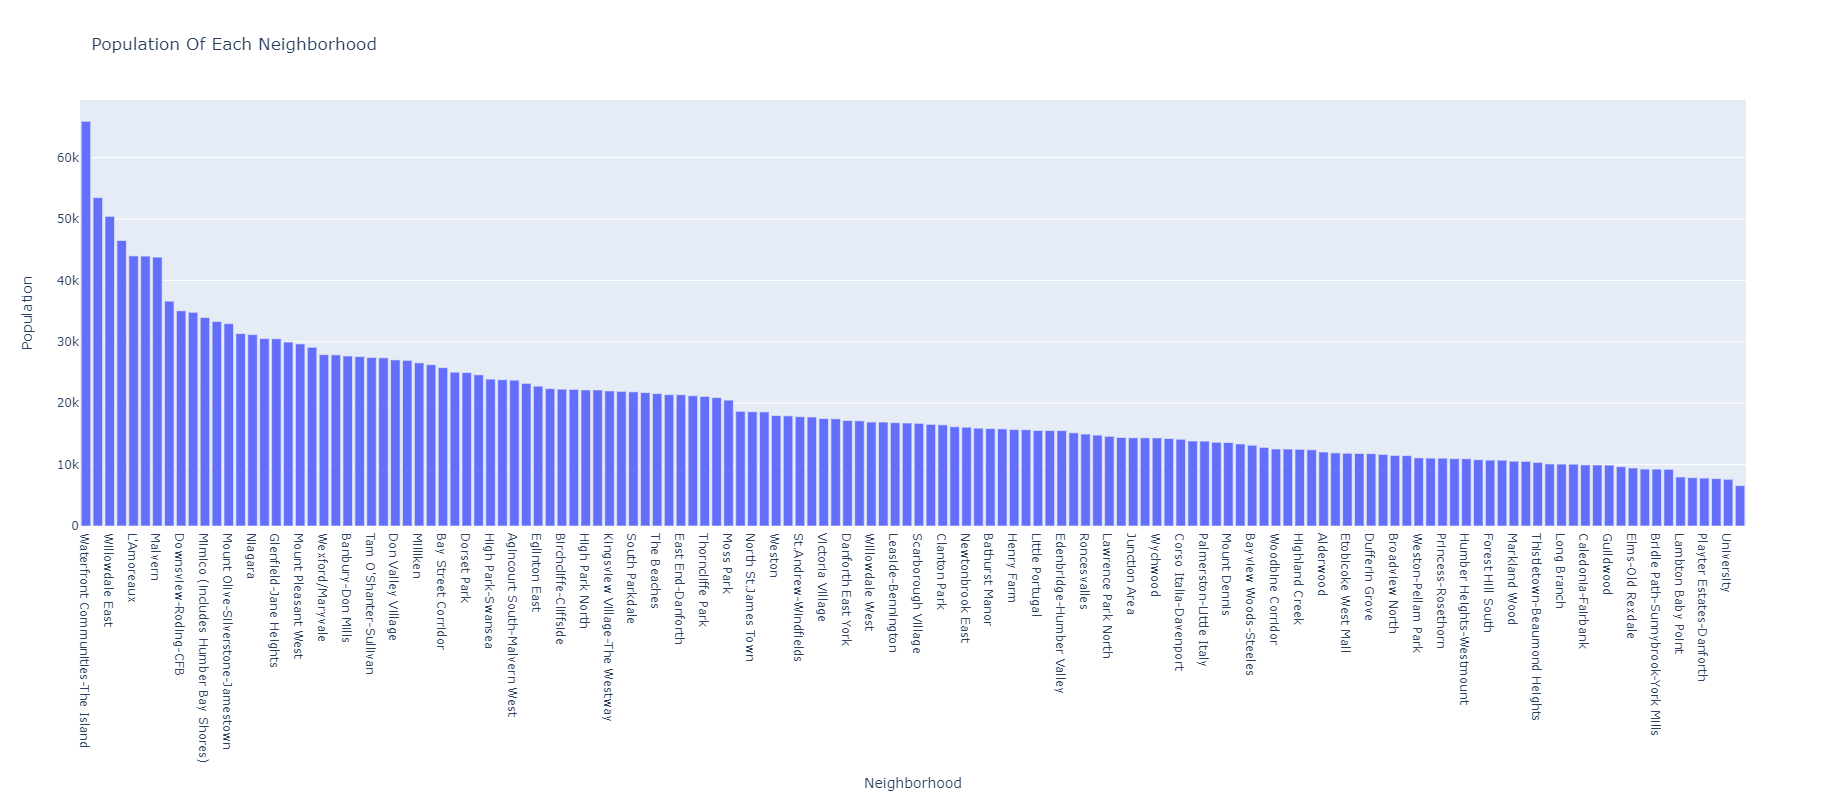

In [40]:
px.bar(df_population,x='Neighborhood',y='Population',height=800,title='Population Of Each Neighborhood').update_xaxes(categoryorder='total descending')

### Get latitudes and longitudes for Neighborhoods using geopy

In [41]:
df_neighborhood = pd.read_csv("Neighbourhoods.csv")
df_neighborhood

_id   AREA_ID  AREA_ATTR_ID  PARENT_AREA_ID  AREA_SHORT_CODE  \
0    5461  25886861      25926662           49885               94   
1    5462  25886820      25926663           49885              100   
2    5463  25886834      25926664           49885               97   
3    5464  25886593      25926665           49885               27   
4    5465  25886688      25926666           49885               31   
..    ...       ...           ...             ...              ...   
135  5596  25886531      25926797           49885              124   
136  5597  25886955      25926798           49885               78   
137  5598  25886737      25926799           49885                6   
138  5599  25886763      25926800           49885               15   
139  5600  25886439      25926801           49885              117   

     AREA_LONG_CODE                          AREA_NAME  \
0                94                      Wychwood (94)   
1               100               Yonge-Eglinton (100)   
2                97                Yonge-St.Clair (97)   
3                27       York University Heights (27)   
4                31            Yorkdale-Glen Park (31)   
..              ...                                ...   
135             124                 Kennedy Park (124)   
136              78          Kensington-Chinatown (78)   
137               6  Kingsview Village-The Westway (6)   
138              15                Kingsway South (15)   
139             117                   L'Amoreaux (117)   

                             AREA_DESC   X   Y  LONGITUDE   LATITUDE  \
0                        Wychwood (94) NaN NaN -79.425515  43.676919   
1                 Yonge-Eglinton (100) NaN NaN -79.403590  43.704689   
2                  Yonge-St.Clair (97) NaN NaN -79.397871  43.687859   
3         York University Heights (27) NaN NaN -79.488883  43.765736   
4              Yorkdale-Glen Park (31) NaN NaN -79.457108  43.714672   
..                                 ...  ..  ..        ...        ...   
135                 Kennedy Park (124) NaN NaN -79.260382  43.725556   
136          Kensington-Chinatown (78) NaN NaN -79.397240  43.653554   
137  Kingsview Village-The Westway (6) NaN NaN -79.547863  43.698993   
138                Kingsway South (15) NaN NaN -79.510577  43.653520   
139                   L'Amoreaux (117) NaN NaN -79.314084  43.795716   

     OBJECTID   Shape__Area  Shape__Length  \
0    16491505  3.217960e+06    7515.779658   
1    16491521  3.160334e+06    7872.021074   
2    16491537  2.222464e+06    8130.411276   
3    16491553  2.541821e+07   25632.335242   
4    16491569  1.156669e+07   13953.408098   
..        ...           ...            ...   
135  16493665  6.861056e+06   10530.202433   
136  16493681  2.933586e+06    6945.056557   
137  16493697  9.694496e+06   14458.764271   
138  16493713  5.043477e+06   11140.672714   
139  16493729  1.374128e+07   17413.886402   

                                              geometry  
0    {u'type': u'Polygon', u'coordinates': (((-79.4...  
1    {u'type': u'Polygon', u'coordinates': (((-79.4...  
2    {u'type': u'Polygon', u'coordinates': (((-79.3...  
3    {u'type': u'Polygon', u'coordinates': (((-79.5...  
4    {u'type': u'Polygon', u'coordinates': (((-79.4...  
..                                                 ...  
135  {u'type': u'Polygon', u'coordinates': (((-79.2...  
136  {u'type': u'Polygon', u'coordinates': (((-79.4...  
137  {u'type': u'Polygon', u'coordinates': (((-79.5...  
138  {u'type': u'Polygon', u'coordinates': (((-79.5...  
139  {u'type': u'Polygon', u'coordinates': (((-79.2...  

[140 rows x 16 columns]

In [42]:
df_neighborhood = pd.read_csv("Neighbourhoods.csv")
df_neighborhood = df_neighborhood[['AREA_NAME','LATITUDE','LONGITUDE']]
df_neighborhood.columns = ['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']
df_neighborhood['Neighborhood'] = df_neighborhood['Neighborhood'].apply(lambda x: re.findall(r'^.*(?=\()',x)[0].strip())
df_neighborhood

Neighborhood  Neighborhood Latitude  \
0                         Wychwood              43.676919   
1                   Yonge-Eglinton              43.704689   
2                   Yonge-St.Clair              43.687859   
3          York University Heights              43.765736   
4               Yorkdale-Glen Park              43.714672   
..                             ...                    ...   
135                   Kennedy Park              43.725556   
136           Kensington-Chinatown              43.653554   
137  Kingsview Village-The Westway              43.698993   
138                 Kingsway South              43.653520   
139                     L'Amoreaux              43.795716   

     Neighborhood Longitude  
0                -79.425515  
1                -79.403590  
2                -79.397871  
3                -79.488883  
4                -79.457108  
..                      ...  
135              -79.260382  
136              -79.397240  
137              -79.547863  
138              -79.510577  
139              -79.314084  

[140 rows x 3 columns]

### Neighborhood Locations on map

In [43]:
neiborhood_map = folium.Map(location=[latitude_toronto,longitude_toronto],zoom_start=11)

for latitude,longitude,name in zip(df_neighborhood['Neighborhood Latitude'],df_neighborhood['Neighborhood Longitude'],df_neighborhood['Neighborhood']):
    label = folium.Popup(f'{name}',parse_html=True)
    folium.CircleMarker(
        [latitude,longitude],
        radius = 5,
        popup=label,
        color='#6930C3',
        fill=True,
        fill_color='#5390D9',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(neiborhood_map)
neiborhood_map

---

## Area Average Income: average individual income in each neighborhood

In [44]:
df_income = df.iloc[2272,6:].transpose().reset_index().copy()
df_income.columns = ['Neighborhood','Average Income($)']
df_income['Average Income($)'] = df_income['Average Income($)'].apply(lambda x: int(x.replace(',','')))
df_income

Neighborhood  Average Income($)
0                 Agincourt North              30414
1    Agincourt South-Malvern West              31825
2                       Alderwood              47709
3                           Annex             112766
4               Banbury-Don Mills              67757
..                            ...                ...
135                      Wychwood              54460
136                Yonge-Eglinton              89330
137                Yonge-St.Clair             114174
138       York University Heights              29958
139            Yorkdale-Glen Park              38527

[140 rows x 2 columns]

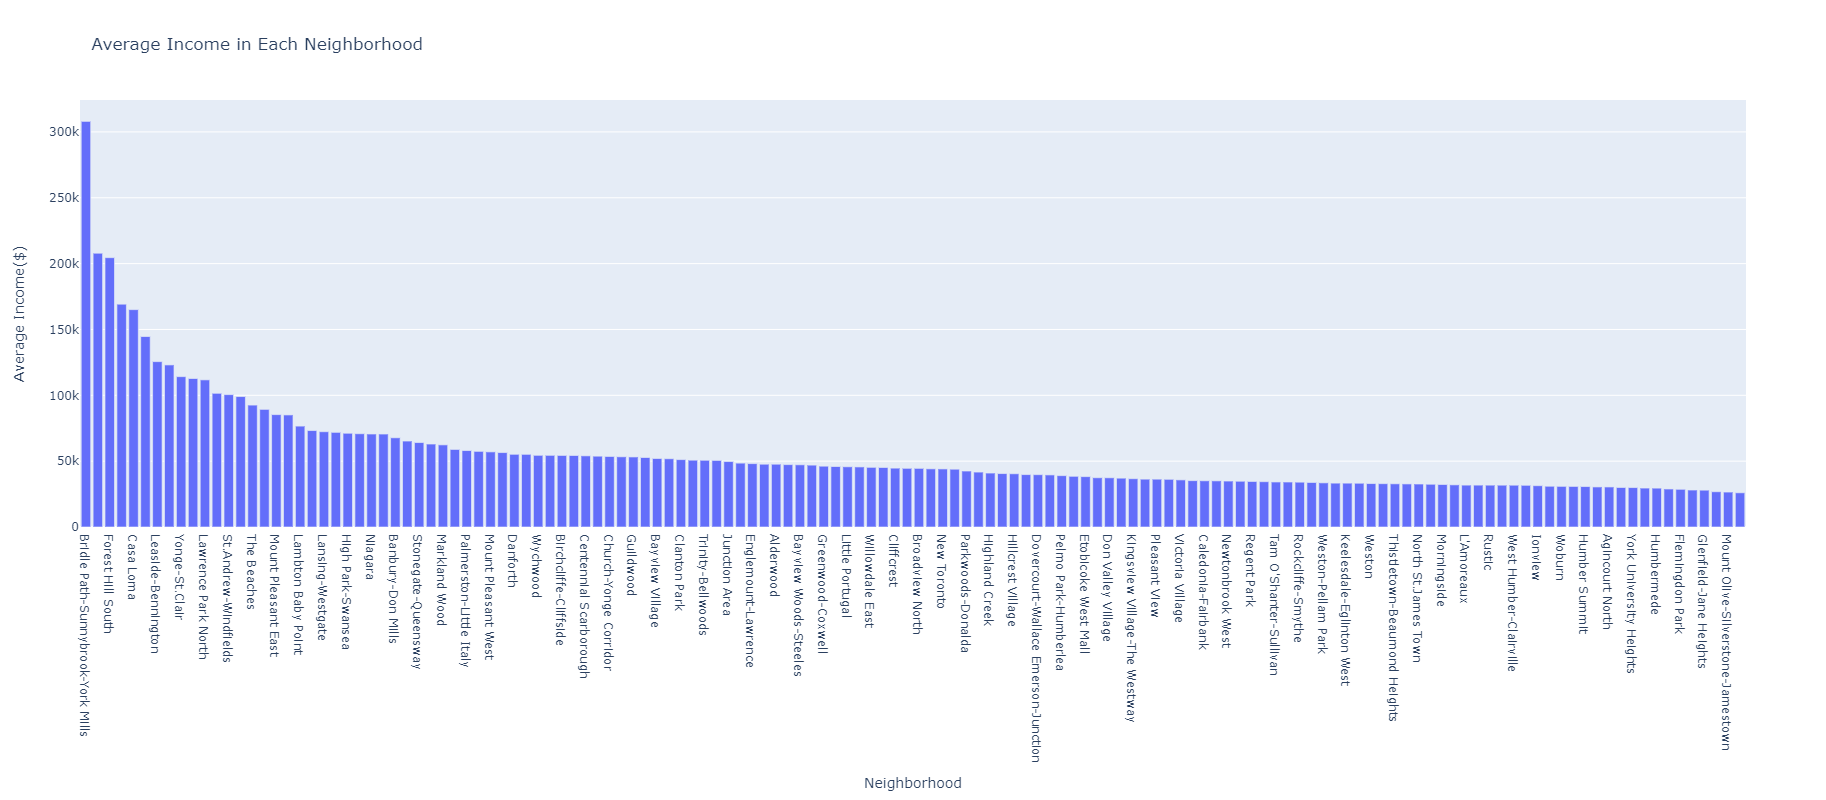

In [45]:
px.bar(data_frame=df_income,x='Neighborhood',y='Average Income($)',height=800,title='Average Income in Each Neighborhood').update_xaxes(categoryorder='total descending')

---

## Target Customer: Asian population in each neighborhood

In [46]:
visible_minority = df.iloc[1337:1349].copy()
groups = ['South Asian','Chinese','Southeast Asian','West Asian','Japanese','Korean']
visible_minority['Characteristic'] = visible_minority['Characteristic'].apply(lambda x: x.lstrip())
asian_population = visible_minority[visible_minority.Characteristic.isin(groups)].iloc[:,5:].transpose().reset_index()
asian_population.columns = ['Neighborhood'] + groups
asian_population = asian_population.set_index('Neighborhood')
asian_population[groups] = asian_population[groups].apply(lambda x: x.str.replace(',','').astype(int))
asian_population['Total Asian Population'] = asian_population[groups].sum(axis=1)
asian_population = asian_population.reset_index()
asian_population.drop(0,inplace=True)
asian_population.drop(groups,axis=1,inplace=True)

In [47]:
df_population = asian_population.merge(df_population,on='Neighborhood')
df_population['Asian Population Percentage'] = df_population['Total Asian Population'] / df_population['Population']
df_population

Neighborhood  Total Asian Population  Population  \
0                 Agincourt North                   22290       29113   
1    Agincourt South-Malvern West                   16010       23757   
2                       Alderwood                     990       12054   
3                           Annex                    4660       30526   
4               Banbury-Don Mills                    9090       27695   
..                            ...                     ...         ...   
135                      Wychwood                    1475       14349   
136                Yonge-Eglinton                    2080       11817   
137                Yonge-St.Clair                    1625       12528   
138       York University Heights                    8080       27593   
139            Yorkdale-Glen Park                    2395       14804   

     Asian Population Percentage  
0                       0.765637  
1                       0.673907  
2                       0.082130  
3                       0.152657  
4                       0.328218  
..                           ...  
135                     0.102795  
136                     0.176018  
137                     0.129709  
138                     0.292828  
139                     0.161781  

[140 rows x 4 columns]

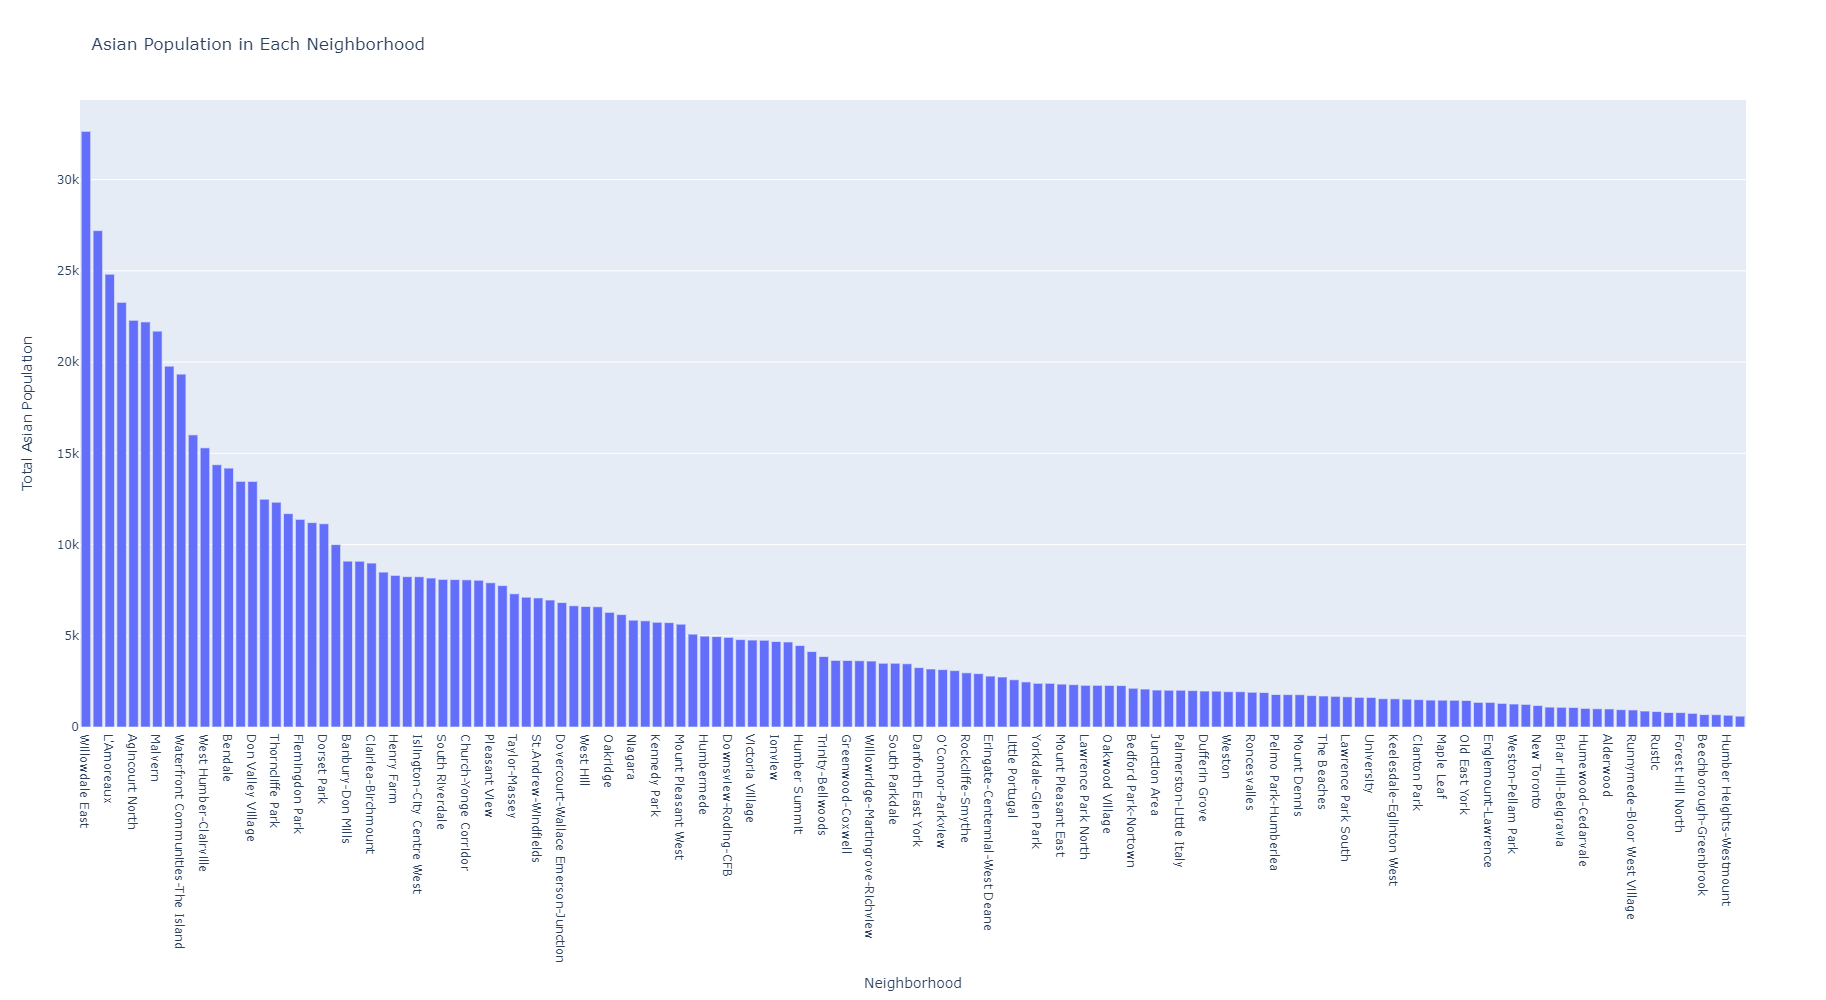

In [48]:
px.bar(data_frame=asian_population,x='Neighborhood',y='Total Asian Population',height=1000,title='Asian Population in Each Neighborhood').update_xaxes(categoryorder='total descending')

---

## Safety: robbery data from public safety data portal

In [49]:
robbery_crime = pd.read_csv("Robbery_2014_to_2019.csv")
robbery_crime = robbery_crime[robbery_crime.reportedyear == 2019]
robbery_crime = robbery_crime[['Neighbourhood','offence','premisetype']]
robbery_crime.Neighbourhood = robbery_crime.Neighbourhood.apply(lambda x: re.findall(r'^.*(?=\()',x)[0].strip())
robbery_crime

Neighbourhood                    offence premisetype
14020      Pelmo Park-Humberlea            Robbery - Other     Outside
14111  Edenbridge-Humber Valley  Robbery - Vehicle Jacking   Apartment
14120                   Malvern        Robbery With Weapon     Outside
14122      Pelmo Park-Humberlea         Robbery - Business  Commercial
14123                Humbermede         Robbery - Business       Other
...                         ...                        ...         ...
21494         Banbury-Don Mills          Robbery - Mugging     Outside
21495                    Woburn  Robbery - Delivery Person   Apartment
21507                     Rouge         Robbery - Swarming     Outside
21508         Parkwoods-Donalda          Robbery - Mugging       Other
21512                    Woburn         Robbery - Business  Commercial

[3417 rows x 3 columns]

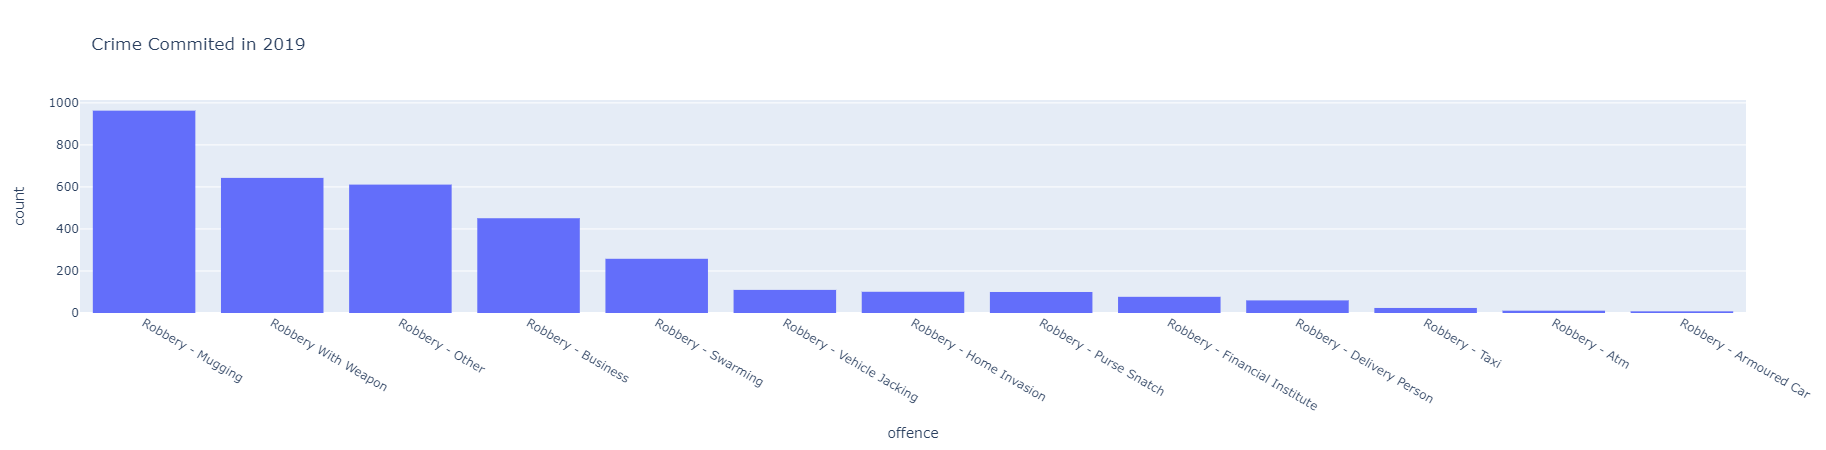

In [50]:
px.histogram(data_frame=robbery_crime,x='offence',title='Crime Commited in 2019').update_xaxes(categoryorder='total descending')

In [51]:
df_safety = robbery_crime.Neighbourhood.value_counts().reset_index()
df_safety.columns=['Neighborhood','Crime Cases']
df_safety

Neighborhood  Crime Cases
0                Church-Yonge Corridor          143
1                            Moss Park          137
2                  Bay Street Corridor          123
3    Waterfront Communities-The Island           95
4              York University Heights           79
..                                 ...          ...
135                             Rustic            3
136                   Woodbine-Lumsden            3
137                 Leaside-Bennington            2
138           Humber Heights-Westmount            2
139             Centennial Scarborough            1

[140 rows x 2 columns]

---

### Get nearby venues for each neighborhood (limit to 50 venues per area in the return list)

#### Since I got the query result previously,I will comment below cell and load the data directly from the saved csv file to save time

In [52]:
# client_id = "WGENET1SWCZBUQYDFZDF5DGW5AIIE1THJCXUCQ1DW4PTHJNH"
# client_secret = "CHCVAO54RWBGKU0IXZGZMVZCEG4DBCAPLOGNEWQNNW3V2MQJ"
# version = "20180605"

In [53]:
# def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
#     venues_list=[]
#     for name, lat, lng in zip(names, latitudes, longitudes):           
#         # create the API request URL
#         url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
#             client_id, 
#             client_secret, 
#             version, 
#             lat, 
#             lng, 
#             'Asian Restaurant',
#             radius, 
#             100)
            
#         # make the GET request
#         results = requests.get(url).json()["response"]['groups'][0]['items']
        
#         # return only relevant information for each nearby venue
#         venues_list.append([(
#             name, 
#             lat, 
#             lng, 
#             v['venue']['name'], 
#             v['venue']['location']['lat'], 
#             v['venue']['location']['lng'],  
#             v['venue']['categories'][0]['name']) for v in results])

#     nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
#     nearby_venues.columns = ['Neighborhood', 
#                   'Neighborhood Latitude', 
#                   'Neighborhood Longitude', 
#                   'Venue', 
#                   'Venue Latitude', 
#                   'Venue Longitude', 
#                   'Venue Category']
    
#     return(nearby_venues)

In [54]:
# venues = getNearbyVenues(names=df_neighborhood['Neighborhood'],latitudes=df_neighborhood['Neighborhood Latitude'],longitudes=df_neighborhood['Neighborhood Longitude'])

In [55]:
# venues.to_csv('Asian_Restaurants.csv',index=False)

### Venue list overview

In [56]:
venues = pd.read_csv("Asian_Restaurants.csv")
venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Yonge-Eglinton              43.704689               -79.40359   
1  Yonge-Eglinton              43.704689               -79.40359   
2  Yonge-Eglinton              43.704689               -79.40359   
3  Yonge-Eglinton              43.704689               -79.40359   
4  Yonge-Eglinton              43.704689               -79.40359   

                 Venue  Venue Latitude  Venue Longitude       Venue Category  
0       Sake Bar Kushi       43.704923       -79.406954  Japanese Restaurant  
1      Mandarin Buffet       43.705819       -79.398051   Chinese Restaurant  
2  Teriyaki Experience       43.706748       -79.398564  Japanese Restaurant  
3           Lemongrass       43.706764       -79.398521     Asian Restaurant  
4        Kanda Izakaya       43.703606       -79.397896  Japanese Restaurant

### Restuarant locations on map

In [57]:
venue_map = folium.Map(location=[latitude_toronto,longitude_toronto],zoom_start=11)

for latitude,longitude,name,category in zip(venues['Venue Latitude'],venues['Venue Longitude'],venues['Venue'],venues['Venue Category']):
    label = folium.Popup(f'{name},{category}',parse_html=True)
    folium.CircleMarker(
        [latitude,longitude],
        radius = 5,
        popup=label,
        color='#6930C3',
        fill=True,
        fill_color='#5390D9',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(venue_map)
venue_map

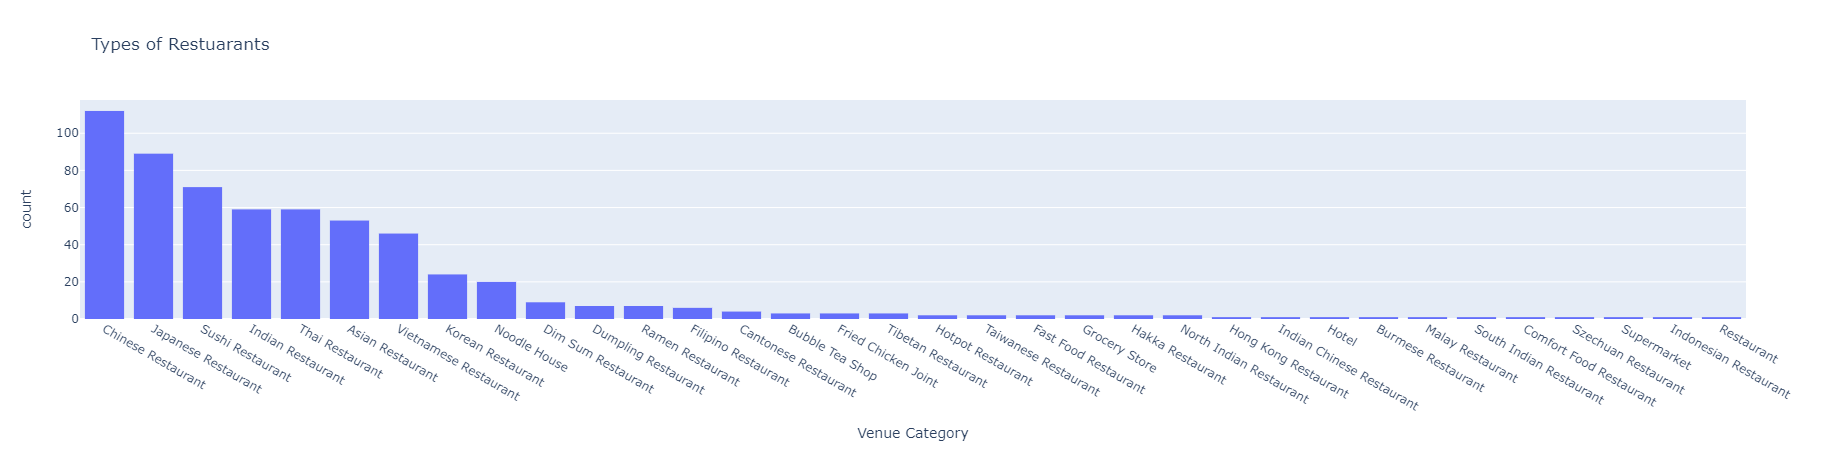

In [58]:
px.histogram(data_frame=venues,x='Venue Category',title='Types of Restuarants').update_xaxes(categoryorder = 'total descending')

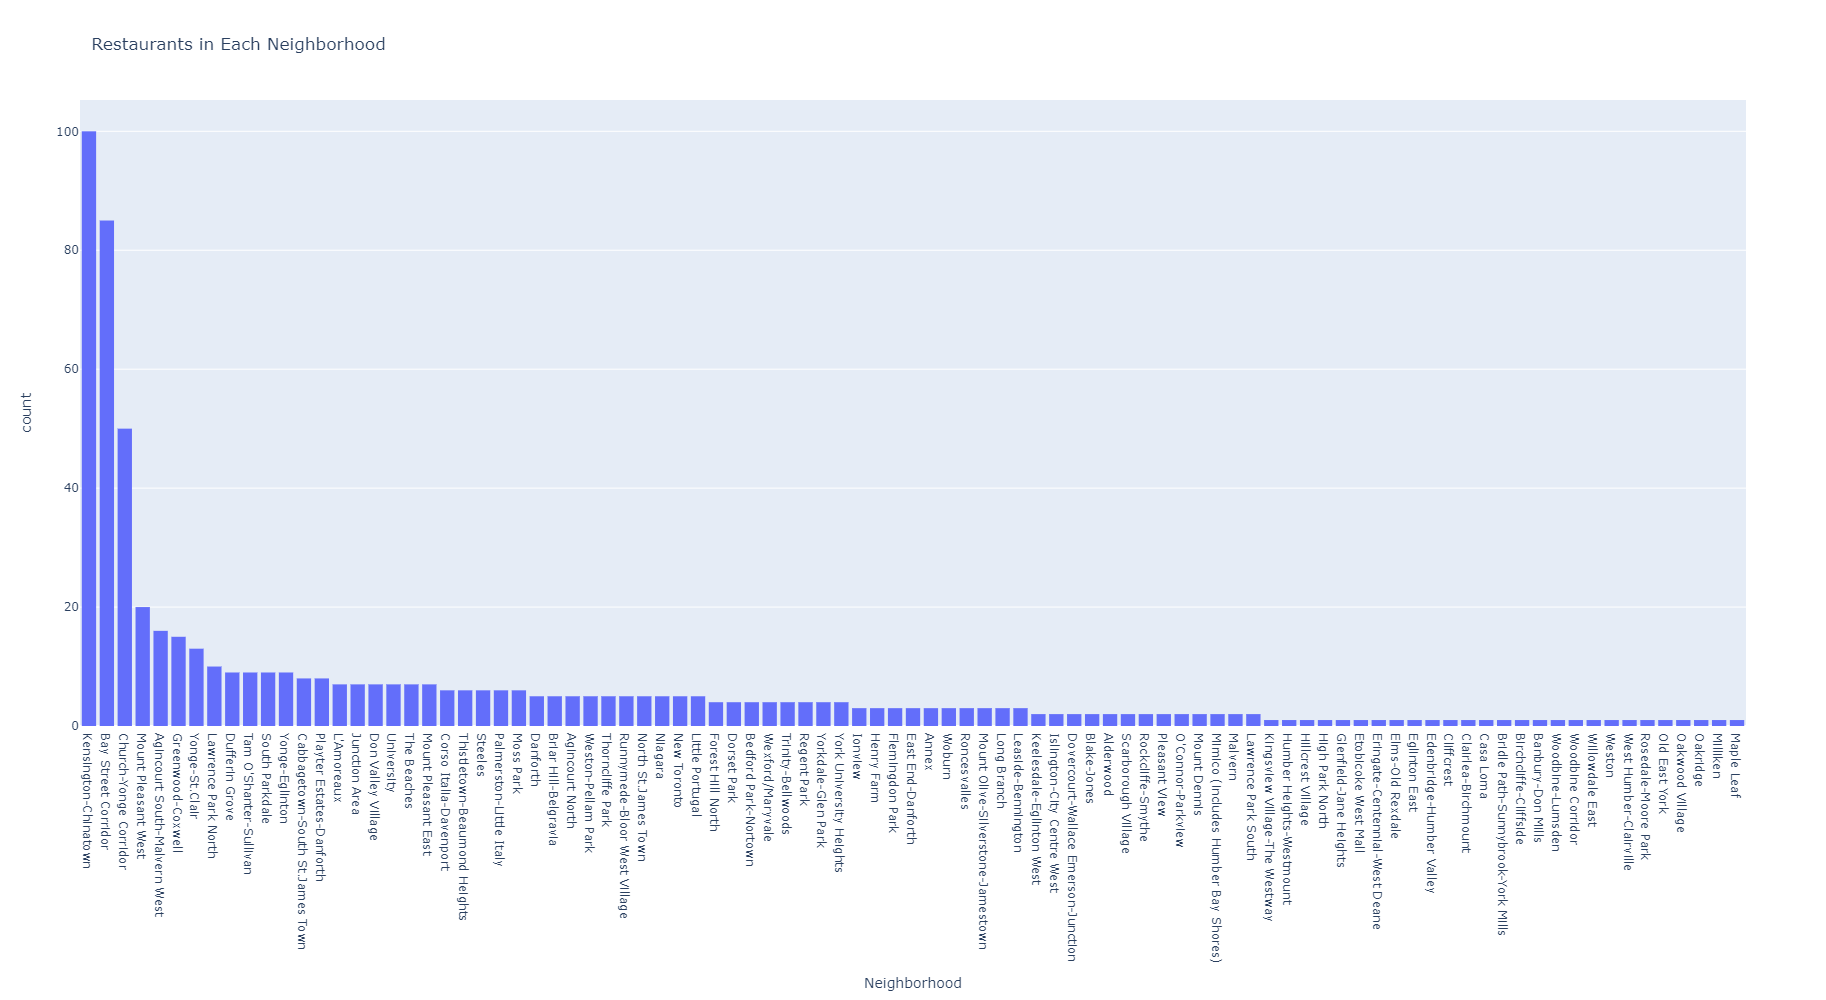

In [59]:
px.histogram(data_frame=venues,x='Neighborhood',height=1000,title='Restaurants in Each Neighborhood').update_xaxes(categoryorder= 'total descending')

In [60]:
df_restaruants = venues.Neighborhood.value_counts().reset_index().copy()
df_restaruants.columns = ['Neighborhood','Restaurants']
df_restaruants = df_neighborhood.merge(df_restaruants,on='Neighborhood',how='left')
df_restaruants.Neighborhood = df_restaruants.Neighborhood.apply(lambda x: x.strip())
df_restaruants.fillna(0,inplace=True)
df_restaruants.Restaurants = df_restaruants.Restaurants.astype(int)
df_restaruants

Neighborhood  Neighborhood Latitude  \
0                         Wychwood              43.676919   
1                   Yonge-Eglinton              43.704689   
2                   Yonge-St.Clair              43.687859   
3          York University Heights              43.765736   
4               Yorkdale-Glen Park              43.714672   
..                             ...                    ...   
135                   Kennedy Park              43.725556   
136           Kensington-Chinatown              43.653554   
137  Kingsview Village-The Westway              43.698993   
138                 Kingsway South              43.653520   
139                     L'Amoreaux              43.795716   

     Neighborhood Longitude  Restaurants  
0                -79.425515            0  
1                -79.403590            9  
2                -79.397871           13  
3                -79.488883            4  
4                -79.457108            4  
..                      ...          ...  
135              -79.260382            0  
136              -79.397240          100  
137              -79.547863            1  
138              -79.510577            0  
139              -79.314084            7  

[140 rows x 4 columns]

---

# Dataset Finalization & Metrics Introduction

## 4 Metrics:
## - `Competition`: How many Asian restaurants are competing in the neighborhood | Float, Range from 0 to 1 | # of restaurants / max(# of restaurants)
## - `Area Average Income`: How much can customers afford | Int, Range from 0 to 300000(CAD\$)
## - `Target Customers`: How large the potential customer group is | Float, Range from 0 to 1 | Asian population / total population (in the same neighborhood)
## - `Safety`: How safe the neighborhood is | Float, Range from 0 to 1 | *abs(# of crime_cases / max(# of crime_cases) - 1)*


## Combine all sub dataframes

In [61]:
df_final = df_restaruants.merge(df_income,on='Neighborhood').merge(df_population,on='Neighborhood').merge(df_safety,on='Neighborhood')
df_final.drop(['Total Asian Population','Population'],axis=1,inplace=True)
df_final.Restaurants = df_final.Restaurants / df_final.Restaurants.max()
df_final['Crime Cases'] = abs((df_final['Crime Cases'] / df_final['Crime Cases'].max()) - 1)
df_final.rename(columns={'Restaurants':'Competition','Crime Cases':'Safety','Asian Population Percentage':'Target Customers','Average Income($)':'Area Average Income'},inplace=True)
df_final

Neighborhood  Neighborhood Latitude  \
0                         Wychwood              43.676919   
1                   Yonge-Eglinton              43.704689   
2                   Yonge-St.Clair              43.687859   
3          York University Heights              43.765736   
4               Yorkdale-Glen Park              43.714672   
..                             ...                    ...   
135                   Kennedy Park              43.725556   
136           Kensington-Chinatown              43.653554   
137  Kingsview Village-The Westway              43.698993   
138                 Kingsway South              43.653520   
139                     L'Amoreaux              43.795716   

     Neighborhood Longitude  Competition  Area Average Income  \
0                -79.425515         0.00                54460   
1                -79.403590         0.09                89330   
2                -79.397871         0.13               114174   
3                -79.488883         0.04                29958   
4                -79.457108         0.04                38527   
..                      ...          ...                  ...   
135              -79.260382         0.00                30974   
136              -79.397240         1.00                37422   
137              -79.547863         0.01                36674   
138              -79.510577         0.00               144642   
139              -79.314084         0.07                31826   

     Target Customers    Safety  
0            0.102795  0.937063  
1            0.176018  0.860140  
2            0.129709  0.972028  
3            0.292828  0.447552  
4            0.161781  0.706294  
..                ...       ...  
135          0.335222  0.811189  
136          0.455001  0.678322  
137          0.231364  0.895105  
138          0.080897  0.916084  
139          0.564067  0.580420  

[140 rows x 7 columns]

---

# K-means Clustering

## Normalizes data

In [62]:
from sklearn.preprocessing import StandardScaler

df_kmeans = df_final.iloc[:,-4:]
df_kmeans = StandardScaler().fit_transform(df_kmeans)
df_kmeans[:5]

array([[-0.35923102, -0.02042728, -0.86948057,  0.66781495],
       [ 0.39767715,  0.88294073, -0.45420648,  0.19102542],
       [ 0.73408078,  1.52656776, -0.7168368 ,  0.88453746],
       [-0.02282739, -0.65519421,  0.20826704, -2.36630025],
       [-0.02282739, -0.43319936, -0.53494969, -0.76255365]])

## Finding optimal number of clusters

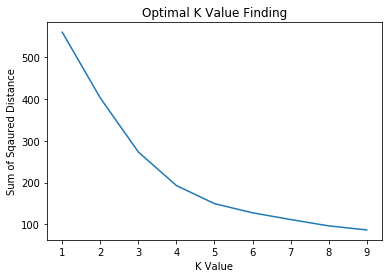

In [63]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k = range(1,10)
distance = []

for i in k:
    clusters = KMeans(n_clusters=i).fit(df_kmeans)
    distance.append(clusters.inertia_)

plt.figure()
plt.plot(k,distance)
plt.xlabel('K Value')
plt.ylabel('Sum of Sqaured Distance')
plt.title('Optimal K Value Finding')
plt.show()

- `4` clusters would be a relative good choice

In [64]:
k=4
model = KMeans(k).fit(df_kmeans)
df_final_with_cluster = df_final.copy()
df_final_with_cluster['Clusters'] = model.labels_
df_final_with_cluster.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0                 Wychwood              43.676919              -79.425515   
1           Yonge-Eglinton              43.704689              -79.403590   
2           Yonge-St.Clair              43.687859              -79.397871   
3  York University Heights              43.765736              -79.488883   
4       Yorkdale-Glen Park              43.714672              -79.457108   

   Competition  Area Average Income  Target Customers    Safety  Clusters  
0         0.00                54460          0.102795  0.937063         1  
1         0.09                89330          0.176018  0.860140         1  
2         0.13               114174          0.129709  0.972028         3  
3         0.04                29958          0.292828  0.447552         0  
4         0.04                38527          0.161781  0.706294         1

## Visualize neighborhoods in each cluster

In [65]:
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
# rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = ['#9B5DE5','#F15BB5','#FEE440','#00BBF9']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_final_with_cluster['Neighborhood Latitude'], df_final_with_cluster['Neighborhood Longitude'], df_final_with_cluster['Neighborhood'], df_final_with_cluster['Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [71]:
pd.set_option('display.max_rows',999)

In [78]:
df_final_with_cluster[df_final_with_cluster.Clusters == 0].sort_values(['Competition','Area Average Income','Target Customers','Safety'],ascending=[True,False,False,False])

Neighborhood  Neighborhood Latitude  \
61   Waterfront Communities-The Island              43.633880   
81                     Bayview Village              43.776361   
82               Bayview Woods-Steeles              43.796802   
24                    Newtonbrook East              43.791536   
69                     Willowdale West              43.771210   
125                     Highland Creek              43.790775   
44                               Rouge              43.821201   
62                           West Hill              43.767490   
85                             Bendale              43.760366   
17                         Morningside              43.782399   
135                       Kennedy Park              43.725556   
128                      Humber Summit              43.758920   
54                       Taylor-Massey              43.694998   
129                         Humbermede              43.743430   
87                         Black Creek              43.764890   
68                     Willowdale East              43.770602   
126                  Hillcrest Village              43.802988   
98                 Clairlea-Birchmount              43.713592   
63              West Humber-Clairville              43.716180   
111                      Eglinton East              43.740922   
15                            Milliken              43.820691   
119             Glenfield-Jane Heights              43.745636   
30                            Oakridge              43.697408   
37                       Pleasant View              43.786982   
47                 Scarborough Village              43.738652   
12                             Malvern              43.803658   
122                         Henry Farm              43.771144   
71                              Woburn              43.766740   
116                    Flemingdon Park              43.715930   
20   Mount Olive-Silverstone-Jamestown              43.746868   
39                         Regent Park              43.659992   
105                        Dorset Park              43.759274   
3              York University Heights              43.765736   
28                 North St.James Town              43.669623   
74                     Agincourt North              43.805441   
57                    Thorncliffe Park              43.707749   
18                           Moss Park              43.656518   
51                             Steeles              43.812959   
104                 Don Valley Village              43.783294   
139                         L'Amoreaux              43.795716   
53              Tam O'Shanter-Sullivan              43.780130   
75        Agincourt South-Malvern West              43.788658   

     Neighborhood Longitude  Competition  Area Average Income  \
61               -79.377202         0.00                70600   
81               -79.377117         0.00                52035   
82               -79.382118         0.00                47246   
24               -79.405937         0.00                45212   
69               -79.427558         0.00                44576   
125              -79.177472         0.00                40972   
44               -79.186343         0.00                39556   
62               -79.176676         0.00                33323   
85               -79.257400         0.00                33256   
17               -79.207041         0.00                32291   
135              -79.260382         0.00                30974   
128              -79.556175         0.00                30731   
54               -79.295901         0.00                30430   
129              -79.542367         0.00                29528   
87               -79.521979         0.00                25989   
68               -79.401484         0.01                45326   
126              -79.354804         0.01                40442   
98               -79.281382         0.01                3623

- Low `Competition`
- Low `Area Average Income`
- High `Target Customers`
- Middle `Safety`

In [79]:
df_final_with_cluster[df_final_with_cluster.Clusters == 1].sort_values(['Competition','Area Average Income','Target Customers','Safety'],ascending=[True,False,False,False])

Neighborhood  Neighborhood Latitude  \
50                  St.Andrew-Windfields              43.756246   
38                    Princess-Rosethorn              43.666051   
5                     Lambton Baby Point              43.657420   
27                       North Riverdale              43.671995   
6                       Lansing-Westgate              43.754271   
124                    High Park-Swansea              43.645065   
130                   Humewood-Cedarvale              43.691370   
52                   Stonegate-Queensway              43.635518   
14                         Markland Wood              43.633542   
0                               Wychwood              43.676919   
96                Centennial Scarborough              43.782376   
49                       South Riverdale              43.649292   
121                            Guildwood              43.748829   
103                   Danforth East York              43.689468   
99                          Clanton Park              43.741978   
113                  Englemount-Lawrence              43.720345   
79                        Bathurst Manor              43.764813   
91                       Broadview North              43.688825   
70      Willowridge-Martingrove-Richview              43.683645   
34                     Parkwoods-Donalda              43.755033   
35                  Pelmo Park-Humberlea              43.717515   
60                      Victoria Village              43.728489   
94                    Caledonia-Fairbank              43.688569   
25                      Newtonbrook West              43.785830   
40                       Rexdale-Kipling              43.723725   
107                 Downsview-Roding-CFB              43.733292   
84               Beechborough-Greenbrook              43.693216   
64                   Westminster-Branson              43.778813   
92                   Brookhaven-Amesbury              43.701326   
46                                Rustic              43.711609   
110             Edenbridge-Humber Valley              43.670886   
78                     Banbury-Don Mills              43.737657   
123                      High Park North              43.657565   
72                     Woodbine Corridor              43.676773   
86                 Birchcliffe-Cliffside              43.694682   
32                         Old East York              43.696781   
73                      Woodbine-Lumsden              43.694107   
114       Eringate-Centennial-West Deane              43.658017   
127             Humber Heights-Westmount              43.692233   
100                           Cliffcrest              43.721121   
31                       Oakwood Village              43.688566   
115                  Etobicoke West Mall              43.645063   
13                            Maple Leaf              43.715574   
137        Kingsview Village-The Westway              43.698993   
65                                Weston              43.702716   
112                     Elms-Old Rexdale              43.721519   
16   Mimico (includes Humber Bay Shores)              43.615924   
132           Islington-City Centre West              43.633463   
88                           Blake-Jones              43.676173   
76                             Alderwood              43.604937   
29                     O'Connor-Parkview              43.706800   
106  Dovercourt-Wallace Emerson-Junction              43.665677   
41                     Rockcliffe-Smythe              43.674790   
134             Keelesdale-Eglinton West              43.685727   
19                          Mount Dennis              43.688144   
109                    East End-Danforth              43.684174   
42                          Roncesvalles              43.646123   
11                           Long Branch              43.592362   
131                              Ionview              43.735364   
117     

- Low `Competition`
- Mid `Area Average Income`
- Low `Target Customers`
- High `Safety`

In [80]:
df_final_with_cluster[df_final_with_cluster.Clusters == 2].sort_values(['Competition','Area Average Income','Target Customers','Safety'],ascending=[True,False,False,False])

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
97   Church-Yonge Corridor              43.659649              -79.379017   
80     Bay Street Corridor              43.657511              -79.385721   
136   Kensington-Chinatown              43.653554              -79.397240   

     Competition  Area Average Income  Target Customers    Safety  Clusters  
97          0.50                53583          0.257339  0.000000         2  
80          0.85                56526          0.483971  0.139860         2  
136         1.00                37422          0.455001  0.678322         2

- High `Competition`
- Mid `Area Average Income`
- High `Target Customers`
- Low `Safety`

In [81]:
df_final_with_cluster[df_final_with_cluster.Clusters == 3].sort_values(['Competition','Area Average Income','Target Customers','Safety'],ascending=[True,False,False,False])

Neighborhood  Neighborhood Latitude  \
118                  Forest Hill South              43.694526   
138                     Kingsway South              43.653520   
90   Bridle Path-Sunnybrook-York Mills              43.731013   
43                 Rosedale-Moore Park              43.682820   
95                           Casa Loma              43.681852   
8                  Lawrence Park South              43.717212   
9                   Leaside-Bennington              43.703797   
77                               Annex              43.671585   
83                Bedford Park-Nortown              43.731486   
7                  Lawrence Park North              43.730060   
2                       Yonge-St.Clair              43.687859   

     Neighborhood Longitude  Competition  Area Average Income  \
118              -79.414318         0.00               204521   
138              -79.510577         0.00               144642   
90               -79.378904         0.01               308010   
43               -79.379669         0.01               207903   
95               -79.408007         0.01               165047   
8                -79.406039         0.02               169203   
9                -79.366072         0.03               125564   
77               -79.404001         0.03               112766   
83               -79.420227         0.04               123077   
7                -79.403978         0.10               111730   
2                -79.397871         0.13               114174   

     Target Customers    Safety  Clusters  
118          0.088520  0.888112         3  
138          0.080897  0.916084         3  
90           0.258472  0.909091         3  
43           0.118052  0.867133         3  
95           0.099380  0.944056         3  
8            0.109032  0.909091         3  
9            0.118552  0.986014         3  
77           0.152657  0.783217         3  
83           0.091453  0.895105         3  
7            0.156432  0.965035         3  
2            0.129709  0.972028         3

- Low `Competition`
- High `Area Average Income`
- Low `Target Customers`
- High `Safety`